In [1]:
import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque, namedtuple
import random, datetime, os, copy

import gymnasium as gym
from gym.spaces import Box
from gym.wrappers import FrameStack

from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros

from tensordict import TensorDict
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage

/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


In [113]:
# Initialize Super Mario environment (in v0.26 change render mode to 'human' to see results on the screen)
if gym.__version__ < '0.26':
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", new_step_api=True)
else:
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", render_mode='rgb', apply_api_compatibility=True)
JoypadSpace.reset = lambda self, **kwargs: self.env.reset(**kwargs)
# Limit the action-space to
#   0. walk right
#   1. jump right
env = JoypadSpace(env, [["right"], ["right", "A"]])

env.reset()
next_state, reward, done, trunc, info = env.step(action=0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/gym/envs/registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


(240, 256, 3),
 0.0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 79}


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [114]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, trunk, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
if gym.__version__ < '0.26':
    env = FrameStack(env, num_stack=4, new_step_api=True)
else:
    env = FrameStack(env, num_stack=4)

In [129]:
class Player():
    def __init__(self, state_dim, action_dim, save_dir):
        # Action Variables
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir

        self.net = Mario(self.state_dim, self.action_dim).float()

        self.exploration_rate = 1
        self.exploration_rate_decay = 0.99999975
        self.exploration_rate_min = 0.1

        self.curr_step = 0
        self.save_every = 5e5

        # Memory Variables
        self.memory = TensorDictReplayBuffer(size = 10000, storage=LazyMemmapStorage(10000))
        self.batch_size = 32

        # Learn Variables
        self.gamma = 0.9
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-4)
        self.loss_fn = nn.SmoothL1Loss()
        self.burnin = 1e4  # min. experiences before training
        self.learn_every = 3  # no. of experiences between updates to Q_online
        self.sync_every = 1e4  # no. of experiences between Q_target & Q_online sync

    def act(self, state):
        #Explore
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)
        #Exploit
        else:
            state = state[0].__array__() if isinstance(state, tuple) else state.__array__()
            state = torch.tensor(state).unsqueeze(0)
            action_values = self.net(state, model="current")
            action_idx = torch.argmax(action_values, axis=1).item()

        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate, self.exploration_rate_min)
        self.curr_step += 1

        return action_idx

    def cache(self, state, next_state, action, reward, done):
        # Adds current info to memory
        def first_if_tuple(x):
            return x[0] if isinstance(x, tuple) else x
        state = first_if_tuple(state).__array__()
        next_state = first_if_tuple(next_state).__array__()
        state = torch.tensor(state)
        next_state = torch.tensor(next_state)
        action = torch.tensor([action])
        reward = torch.tensor([reward])
        done = torch.tensor([done])

        self.memory.add(TensorDict({"state": state, "next_state": next_state, "action": action, "reward": reward, "done": done}, batch_size=[]))
    
    def recall(self):
        # Retrieves the last batch of memories from the memory
        memory_batch = self.memory.sample(batch_size=self.batch_size)
        state, next_state, action, reward, done = (memory_batch.get(key) for key in ("state", "next_state", "action", "reward", "done"))

        return state, next_state, action, reward, done
    
    def Q_current(self, state, action):
        current_Q = self.net(state, model="current")
        current_Q = current_Q[np.arange(0, self.batch_size), action]  # Q_online(s,a)
        return current_Q

    def Q_target(self, reward, next_state, done):
        # Current reward + Q of the next state
        with torch.no_grad():
            next_state_Q = self.net(next_state, model="current")
            best_action = torch.argmax(next_state_Q, axis=1)
            next_Q = self.net(next_state, model="target")
            next_Q = next_Q[np.arange(0, self.batch_size), best_action]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()
    
    def optim_Q_current(self, current_est, target):
        loss = self.loss_fn(current_est, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
    def sync_target(self):
        self.net.target.load_state_dict(self.net.current.state_dict())

    def learn(self):
        if self.curr_step % self.sync_every == 0:
            self.sync_target()

        if self.curr_step < self.burnin:
            return None, None

        if self.curr_step % self.learn_every != 0:
            return None, None

        # Sample from memory
        state, next_state, action, reward, done = self.recall()

        # Get TD Estimate
        td_est = self.Q_current(state, action)

        # Get TD Target
        td_tgt = self.Q_target(reward, next_state, done)

        # Backpropagate loss through Q_online
        loss = self.optim_Q_current(td_est, td_tgt)

        return (td_est.mean().item(), loss)
    
    def save(self):
        torch.save(self.net.state_dict(), self.save_dir)

In [130]:
import numpy as np
import time, datetime
import matplotlib.pyplot as plt


class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # History metrics
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # Moving averages, added for every call to record()
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # Current episode metric
        self.init_episode()

        # Timing
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self):
        "Mark end of episode"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        for metric in ["ep_lengths", "ep_avg_losses", "ep_avg_qs", "ep_rewards"]:
            plt.clf()
            plt.plot(getattr(self, f"moving_avg_{metric}"), label=f"moving_avg_{metric}")
            plt.legend()
            plt.savefig(getattr(self, f"{metric}_plot"))

In [131]:
class Mario(nn.Module):

    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim

        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 84:
            raise ValueError(f"Expecting input width: 84, got: {w}")
        self.current = nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )
        self.target = copy.deepcopy(self.current)
        for p in self.target.parameters():
            p.requires_grad = False
    
    def forward(self, x, model):
        if model == "current":
            return self.current(x)
        if model == "target":
            return self.target(x)

In [132]:
save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

mario = Player(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir)

logger = MetricLogger(save_dir)

Creating a MemmapStorage...
The storage is being created: 
	action: /var/folders/nx/23kzl3_d08d89039y9hptpf40000gn/T/tmpv6wgtfb2, 0.0762939453125 Mb of storage (size: torch.Size([10000, 1])).
	done: /var/folders/nx/23kzl3_d08d89039y9hptpf40000gn/T/tmpysd9wd74, 0.0095367431640625 Mb of storage (size: torch.Size([10000, 1])).
	next_state: /var/folders/nx/23kzl3_d08d89039y9hptpf40000gn/T/tmpep9xcf29, 1076.66015625 Mb of storage (size: torch.Size([10000, 4, 84, 84])).
	reward: /var/folders/nx/23kzl3_d08d89039y9hptpf40000gn/T/tmp0k6o4rm2, 0.03814697265625 Mb of storage (size: torch.Size([10000, 1])).
	state: /var/folders/nx/23kzl3_d08d89039y9hptpf40000gn/T/tmpch3ue62v, 1076.66015625 Mb of storage (size: torch.Size([10000, 4, 84, 84])).
Episode 0 - Step 258 - Epsilon 0.9999355020720093 - Mean Reward 1019.0 - Mean Length 258.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 6.057 - Time 2023-10-28T01:23:49


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 20 - Step 3832 - Epsilon 0.9990424586157298 - Mean Reward 550.19 - Mean Length 182.476 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 28.331 - Time 2023-10-28T01:24:17


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 40 - Step 7686 - Epsilon 0.9980803446592821 - Mean Reward 606.585 - Mean Length 187.463 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 31.093 - Time 2023-10-28T01:24:48


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 60 - Step 12538 - Epsilon 0.9968704070253283 - Mean Reward 653.607 - Mean Length 205.541 - Mean Loss 0.617 - Mean Q Value 0.614 - Time Delta 93.671 - Time 2023-10-28T01:26:22


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 80 - Step 16542 - Epsilon 0.9958730388891176 - Mean Reward 659.827 - Mean Length 204.222 - Mean Loss 1.171 - Mean Q Value 1.034 - Time Delta 115.001 - Time 2023-10-28T01:28:17


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 100 - Step 19998 - Epsilon 0.9950129760765267 - Mean Reward 647.05 - Mean Length 197.4 - Mean Loss 1.522 - Mean Q Value 1.587 - Time Delta 100.202 - Time 2023-10-28T01:29:57


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 120 - Step 25746 - Epsilon 0.9935841690947892 - Mean Reward 680.09 - Mean Length 219.14 - Mean Loss 2.1 - Mean Q Value 3.057 - Time Delta 165.462 - Time 2023-10-28T01:32:43


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 140 - Step 29077 - Epsilon 0.9927571061905919 - Mean Reward 645.71 - Mean Length 213.91 - Mean Loss 2.632 - Mean Q Value 4.036 - Time Delta 94.926 - Time 2023-10-28T01:34:18


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 160 - Step 34358 - Epsilon 0.9914472832943285 - Mean Reward 631.18 - Mean Length 218.2 - Mean Loss 2.782 - Mean Q Value 4.663 - Time Delta 152.629 - Time 2023-10-28T01:36:50


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 180 - Step 38577 - Epsilon 0.9904021054390432 - Mean Reward 635.13 - Mean Length 220.35 - Mean Loss 2.758 - Mean Q Value 5.25 - Time Delta 120.878 - Time 2023-10-28T01:38:51


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 200 - Step 43746 - Epsilon 0.9891230847434642 - Mean Reward 637.84 - Mean Length 237.48 - Mean Loss 2.723 - Mean Q Value 5.6 - Time Delta 148.299 - Time 2023-10-28T01:41:19


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 220 - Step 47464 - Epsilon 0.9882041218753543 - Mean Reward 625.91 - Mean Length 217.18 - Mean Loss 2.691 - Mean Q Value 5.28 - Time Delta 106.284 - Time 2023-10-28T01:43:06


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 240 - Step 51277 - Epsilon 0.9872625650191865 - Mean Reward 661.0 - Mean Length 222.0 - Mean Loss 2.734 - Mean Q Value 5.694 - Time Delta 108.155 - Time 2023-10-28T01:44:54


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 260 - Step 55670 - Epsilon 0.9861788989485971 - Mean Reward 681.54 - Mean Length 213.12 - Mean Loss 2.776 - Mean Q Value 6.645 - Time Delta 121.079 - Time 2023-10-28T01:46:55


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 280 - Step 58613 - Epsilon 0.9854535845906678 - Mean Reward 656.99 - Mean Length 200.36 - Mean Loss 2.789 - Mean Q Value 7.78 - Time Delta 81.134 - Time 2023-10-28T01:48:16


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 300 - Step 66645 - Epsilon 0.9834767789225439 - Mean Reward 698.24 - Mean Length 228.99 - Mean Loss 2.802 - Mean Q Value 8.815 - Time Delta 220.806 - Time 2023-10-28T01:51:57


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 320 - Step 72612 - Epsilon 0.9820107709846646 - Mean Reward 725.72 - Mean Length 251.48 - Mean Loss 2.719 - Mean Q Value 9.446 - Time Delta 175.412 - Time 2023-10-28T01:54:52


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 340 - Step 78518 - Epsilon 0.9805619017908951 - Mean Reward 734.67 - Mean Length 272.41 - Mean Loss 2.632 - Mean Q Value 9.806 - Time Delta 172.662 - Time 2023-10-28T01:57:45


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 360 - Step 82585 - Epsilon 0.9795654220237959 - Mean Reward 712.6 - Mean Length 269.15 - Mean Loss 2.591 - Mean Q Value 9.628 - Time Delta 119.595 - Time 2023-10-28T01:59:44


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 380 - Step 88027 - Epsilon 0.9782336292579279 - Mean Reward 759.62 - Mean Length 294.14 - Mean Loss 2.604 - Mean Q Value 9.399 - Time Delta 155.301 - Time 2023-10-28T02:02:20


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 400 - Step 93242 - Epsilon 0.9769590880263898 - Mean Reward 741.59 - Mean Length 265.97 - Mean Loss 2.615 - Mean Q Value 9.221 - Time Delta 150.514 - Time 2023-10-28T02:04:50


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 420 - Step 97322 - Epsilon 0.9759630976733963 - Mean Reward 728.13 - Mean Length 247.1 - Mean Loss 2.715 - Mean Q Value 9.406 - Time Delta 117.08 - Time 2023-10-28T02:06:47


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 440 - Step 101161 - Epsilon 0.9750268663191328 - Mean Reward 721.12 - Mean Length 226.43 - Mean Loss 2.81 - Mean Q Value 10.106 - Time Delta 111.417 - Time 2023-10-28T02:08:39


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 460 - Step 105022 - Epsilon 0.9740861755925988 - Mean Reward 707.22 - Mean Length 224.37 - Mean Loss 2.863 - Mean Q Value 11.446 - Time Delta 109.852 - Time 2023-10-28T02:10:29


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 480 - Step 109256 - Epsilon 0.9730556507482688 - Mean Reward 682.91 - Mean Length 212.29 - Mean Loss 2.874 - Mean Q Value 12.507 - Time Delta 122.421 - Time 2023-10-28T02:12:31


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 500 - Step 114505 - Epsilon 0.9717795957455916 - Mean Reward 653.2 - Mean Length 212.63 - Mean Loss 2.866 - Mean Q Value 13.498 - Time Delta 153.927 - Time 2023-10-28T02:15:05


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 520 - Step 117103 - Epsilon 0.9711486297475871 - Mean Reward 621.99 - Mean Length 197.81 - Mean Loss 2.861 - Mean Q Value 14.542 - Time Delta 76.956 - Time 2023-10-28T02:16:22


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 540 - Step 121594 - Epsilon 0.9700588843574609 - Mean Reward 630.94 - Mean Length 204.33 - Mean Loss 2.87 - Mean Q Value 15.5 - Time Delta 132.325 - Time 2023-10-28T02:18:34


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 560 - Step 124824 - Epsilon 0.9692758778917613 - Mean Reward 628.31 - Mean Length 198.02 - Mean Loss 2.879 - Mean Q Value 16.378 - Time Delta 93.657 - Time 2023-10-28T02:20:08


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 580 - Step 130000 - Epsilon 0.9680224458943157 - Mean Reward 644.54 - Mean Length 207.44 - Mean Loss 2.883 - Mean Q Value 17.211 - Time Delta 152.868 - Time 2023-10-28T02:22:41


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 600 - Step 134165 - Epsilon 0.9670150169801586 - Mean Reward 659.95 - Mean Length 196.6 - Mean Loss 2.925 - Mean Q Value 18.307 - Time Delta 121.229 - Time 2023-10-28T02:24:42


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 620 - Step 138959 - Epsilon 0.9658567435713453 - Mean Reward 678.12 - Mean Length 218.56 - Mean Loss 2.94 - Mean Q Value 19.055 - Time Delta 139.597 - Time 2023-10-28T02:27:02


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 640 - Step 143304 - Epsilon 0.9648081511722718 - Mean Reward 671.75 - Mean Length 217.1 - Mean Loss 2.929 - Mean Q Value 19.383 - Time Delta 124.525 - Time 2023-10-28T02:29:06


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 660 - Step 147052 - Epsilon 0.9639045492251712 - Mean Reward 699.48 - Mean Length 222.28 - Mean Loss 2.929 - Mean Q Value 19.345 - Time Delta 107.68 - Time 2023-10-28T02:30:54


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 680 - Step 151948 - Epsilon 0.9627254516642816 - Mean Reward 656.1 - Mean Length 219.48 - Mean Loss 2.923 - Mean Q Value 19.516 - Time Delta 140.282 - Time 2023-10-28T02:33:14


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 700 - Step 156940 - Epsilon 0.9615247195630208 - Mean Reward 658.61 - Mean Length 227.75 - Mean Loss 2.867 - Mean Q Value 19.048 - Time Delta 133.941 - Time 2023-10-28T02:35:28


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 720 - Step 160273 - Epsilon 0.9607238626935584 - Mean Reward 646.18 - Mean Length 213.14 - Mean Loss 2.844 - Mean Q Value 18.847 - Time Delta 95.534 - Time 2023-10-28T02:37:04


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 740 - Step 163294 - Epsilon 0.9599985498362381 - Mean Reward 610.41 - Mean Length 199.9 - Mean Loss 2.851 - Mean Q Value 18.695 - Time Delta 92.013 - Time 2023-10-28T02:38:36


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 760 - Step 167028 - Epsilon 0.9591028092298439 - Mean Reward 607.23 - Mean Length 199.76 - Mean Loss 2.838 - Mean Q Value 18.854 - Time Delta 110.945 - Time 2023-10-28T02:40:27


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 780 - Step 170843 - Epsilon 0.9581885008912193 - Mean Reward 629.09 - Mean Length 188.95 - Mean Loss 2.841 - Mean Q Value 19.089 - Time Delta 102.388 - Time 2023-10-28T02:42:09


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 800 - Step 176487 - Epsilon 0.9568374501378523 - Mean Reward 651.3 - Mean Length 195.47 - Mean Loss 2.884 - Mean Q Value 20.021 - Time Delta 153.868 - Time 2023-10-28T02:44:43


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 820 - Step 181065 - Epsilon 0.9557429759715188 - Mean Reward 654.48 - Mean Length 207.92 - Mean Loss 2.913 - Mean Q Value 20.407 - Time Delta 132.648 - Time 2023-10-28T02:46:55


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 840 - Step 185276 - Epsilon 0.954737346858622 - Mean Reward 708.62 - Mean Length 219.82 - Mean Loss 2.874 - Mean Q Value 20.661 - Time Delta 120.655 - Time 2023-10-28T02:48:56


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 860 - Step 189023 - Epsilon 0.9538434152976505 - Mean Reward 680.81 - Mean Length 219.95 - Mean Loss 2.884 - Mean Q Value 20.745 - Time Delta 112.403 - Time 2023-10-28T02:50:48


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 880 - Step 192694 - Epsilon 0.9529684269654509 - Mean Reward 680.44 - Mean Length 218.51 - Mean Loss 2.89 - Mean Q Value 21.115 - Time Delta 106.457 - Time 2023-10-28T02:52:35


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 900 - Step 197564 - Epsilon 0.951808893769584 - Mean Reward 665.74 - Mean Length 210.77 - Mean Loss 2.891 - Mean Q Value 21.075 - Time Delta 139.898 - Time 2023-10-28T02:54:55


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 920 - Step 201623 - Epsilon 0.950843535455338 - Mean Reward 687.46 - Mean Length 205.58 - Mean Loss 2.903 - Mean Q Value 21.894 - Time Delta 117.156 - Time 2023-10-28T02:56:52


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 940 - Step 206290 - Epsilon 0.949734785564341 - Mean Reward 667.36 - Mean Length 210.14 - Mean Loss 2.956 - Mean Q Value 22.9 - Time Delta 131.52 - Time 2023-10-28T02:59:03


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 960 - Step 210869 - Epsilon 0.948648198586472 - Mean Reward 692.12 - Mean Length 218.46 - Mean Loss 2.953 - Mean Q Value 23.191 - Time Delta 132.75 - Time 2023-10-28T03:01:16


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 980 - Step 214837 - Epsilon 0.9477076060667894 - Mean Reward 692.44 - Mean Length 221.43 - Mean Loss 2.931 - Mean Q Value 22.971 - Time Delta 121.924 - Time 2023-10-28T03:03:18


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 1000 - Step 218266 - Epsilon 0.946895531744952 - Mean Reward 668.81 - Mean Length 207.02 - Mean Loss 2.943 - Mean Q Value 23.349 - Time Delta 98.512 - Time 2023-10-28T03:04:57


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 1020 - Step 222196 - Epsilon 0.9459656636411575 - Mean Reward 674.82 - Mean Length 205.73 - Mean Loss 2.934 - Mean Q Value 23.769 - Time Delta 112.87 - Time 2023-10-28T03:06:50


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 1040 - Step 226600 - Epsilon 0.9449247284551932 - Mean Reward 656.42 - Mean Length 203.1 - Mean Loss 2.922 - Mean Q Value 24.115 - Time Delta 126.877 - Time 2023-10-28T03:08:56


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 1060 - Step 230573 - Epsilon 0.94398664780269 - Mean Reward 640.77 - Mean Length 197.04 - Mean Loss 2.935 - Mean Q Value 24.445 - Time Delta 114.587 - Time 2023-10-28T03:10:51


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 1080 - Step 236661 - Epsilon 0.942550992755711 - Mean Reward 670.44 - Mean Length 218.24 - Mean Loss 2.941 - Mean Q Value 24.703 - Time Delta 174.206 - Time 2023-10-28T03:13:45


/Users/brianchen/miniconda3/envs/pokerRL/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


KeyboardInterrupt: 

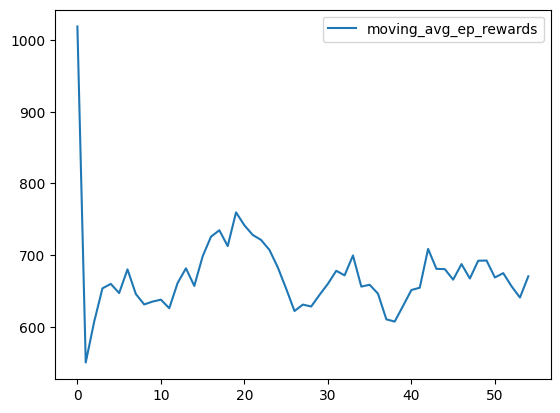

In [133]:
episodes = 40000
for e in range(episodes):

    state = env.reset()

    # Play the game!
    while True:

        # Run agent on the state
        action = mario.act(state)

        # Agent performs action
        next_state, reward, done, trunc, info = env.step(action)

        # Remember
        mario.cache(state, next_state, action, reward, done)

        # Learn
        q, loss = mario.learn()

        # Logging
        logger.log_step(reward, loss, q)

        # Update state
        state = next_state

        # Check if end of game
        if done or info["flag_get"]:
            break

    logger.log_episode()

    if e % 20 == 0:
        logger.record(episode=e, epsilon=mario.exploration_rate, step=mario.curr_step)

In [134]:
mario.save()

RuntimeError: File checkpoints/2023-10-28T01-23-43 cannot be opened.

In [135]:
save_path = (mario.save_dir / f"mario_net_{int(mario.curr_step // mario.save_every)}.chkpt")
torch.save(dict(model=mario.net.state_dict(), exploration_rate=mario.exploration_rate),save_path,)
print(f"MarioNet saved to {save_path} at step {mario.curr_step}")

MarioNet saved to checkpoints/2023-10-28T01-23-43/mario_net_0.chkpt at step 240021
